In [36]:
from src.dataset.data_reader import BIDSDatasetReader
import mne
import numpy as np
from matplotlib import pyplot as plt

In [4]:
raw = BIDSDatasetReader(
    sub_id='01', ses_id='01'
)
data = raw.raw

╭─────────────────────────────────────────╮
│ 🚀 Initializing BIDSDatasetReader Class │
╰─────────────────────────────────────────╯

Loading Processed EEG Data

Opening raw data file /home/owaismujtaba/projects/elsavier/BIDS/derivatives/processed_eeg/sub-01_ses-01_processed-raw.fif...
    Range : 0 ... 6306999 =      0.000 ...  6306.999 secs
Ready.
Reading 0 ... 6306999  =      0.000 ...  6306.999 secs...


In [46]:
import numpy as np
import mne

class SpeechEventExtractor:
    def __init__(self,raw, tmin=-0.2, tmax=0.8):
        self.raw = raw
        self.annotations = self.raw.annotations
        self.tmin = tmin
        self.tmax = tmax
    
    def get_silence_events(self):
        return self._filter_events(['Experiment','Words', 'Start', 'Speech','Audio', 'silence'])
    
    def get_overt_speaking_events(self):
        return self._filter_events(['Real', 'Words', 'Experiment', 'Start', 'Speech', 'Audio'], exclude=['silence'])
    
    def get_covert_speaking_events(self):
        return self._filter_events(['Silent', 'Words', 'Experiment', 'Start', 'Speech', 'Audio'], exclude=['silence'])
    
    def _filter_events(self, criteria, exclude=None):
        exclude = exclude or []
        return [event for event in self.annotations 
                if all(criterion in event['description'] for criterion in criteria) 
                and all(excl not in event['description'] for excl in exclude)]
    
    def get_events_info(self, filtered_events):
        event_list = []
        event_id_map = {}
        event_counter = 1

        for event in filtered_events:
            onset_sample = int(event['onset'] * self.raw.info['sfreq'])
            description = event['description']

            if description not in event_id_map:
                event_id_map[description] = event_counter
                event_counter += 1

            event_list.append([onset_sample, 0, event_id_map[description]])

        events = np.array(event_list)
        return events, event_id_map
    
    def create_epochs(self, event_type):
        if event_type == 'silence':
            filtered_events = self.get_silence_events()
        elif event_type == 'overt':
            filtered_events = self.get_overt_speaking_events()
        elif event_type == 'covert':
            filtered_events = self.get_covert_speaking_events()
        else:
            raise ValueError("Invalid event type. Choose from 'silence', 'overt', or 'covert'.")
        
        events, event_id_map = self.get_events_info(filtered_events)
        epochs = mne.Epochs(self.raw, events, event_id=event_id_map, tmin=self.tmin, tmax=self.tmax, 
                            baseline=(None, 0), detrend=1, preload=True)
        return epochs
    
    def plot_erp(self):
        event_types = ['silence', 'overt', 'covert']
        colors = {'silence': 'blue', 'overt': 'green', 'covert': 'red'}
        channels = ['F3', 'F7']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
        
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        for event_type in event_types:
            epochs = self.create_epochs(event_type)
            evoked = epochs.average()
            
            # Plot F3
            ch_idx_f3 = epochs.ch_names.index('F3')
            axes[0].plot(evoked.times, evoked.data[ch_idx_f3], label=f'{event_type} - F3', color=colors[event_type])
            
            # Plot F7
            ch_idx_f7 = epochs.ch_names.index('F7')
            axes[1].plot(evoked.times, evoked.data[ch_idx_f7], label=f'{event_type} - F7', color=colors[event_type])
            
            # Plot all channels (mean across all)
            axes[2].plot(evoked.times, evoked.data.mean(axis=0), label=f'{event_type} - All', color=colors[event_type])
        
        
        
        for ax in axes:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

In [47]:
speech = SpeechEventExtractor(
    raw=data
)

Not setting metadata
10 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points ...
0 bad epochs dropped


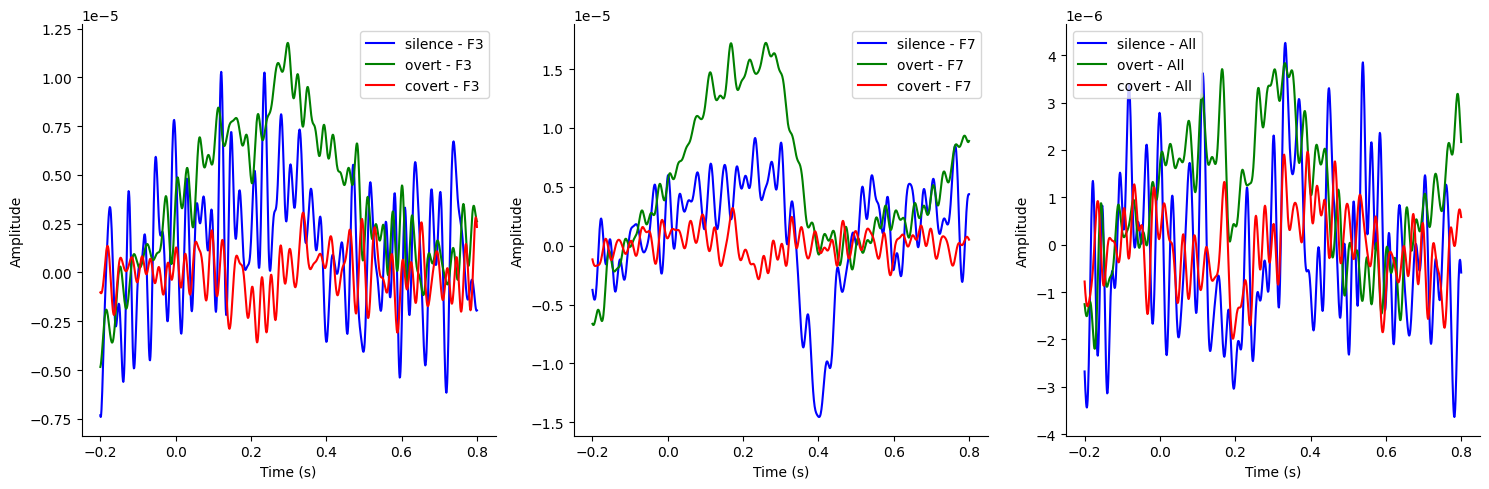

In [48]:
speech.plot_erp()

In [81]:
import matplotlib.pyplot as plt

def load_subject_data(subject_ids, session_ids):
    subjects_data = {}
    for index in range(len(session_ids)):
        subject_id = subject_ids[index]
        session_id = session_ids[index]
        raw = BIDSDatasetReader(sub_id=subject_id, ses_id=session_id)
        extractor = SpeechEventExtractor(
            raw=raw.raw  # Corrected data assignment
        )
        subjects_data[(subject_id, session_id)] = extractor
    return subjects_data

def plot_erp_all_subjects_sessions(subjects_data):
    event_types = ['silence', 'overt', 'covert']
    colors = {'silence': 'blue', 'overt': 'green', 'covert': 'red'}
    channels = ['F3', 'F7']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    for (subject_id, session_id), extractor in subjects_data.items():
        for event_type in event_types:
            epochs = extractor.create_epochs(event_type)
            evoked = epochs.average()
            
            # Plot F3
            ch_idx_f3 = epochs.ch_names.index('F3')
            axes[0].plot(evoked.times, evoked.data[ch_idx_f3], label=f'S{subject_id} Sess{session_id} {event_type}', color=colors[event_type], alpha=0.5)
            
            # Plot F7
            ch_idx_f7 = epochs.ch_names.index('F7')
            axes[1].plot(evoked.times, evoked.data[ch_idx_f7], label=f'S{subject_id} Sess{session_id} {event_type}', color=colors[event_type], alpha=0.5)
            
            # Plot all channels (mean across all)
            axes[2].plot(evoked.times, evoked.data.mean(axis=0), label=f'S{subject_id} Sess{session_id} {event_type}', color=colors[event_type], alpha=0.5)
    
    axes[0].set_title('ERP Comparison for F3')
    axes[1].set_title('ERP Comparison for F7')
    axes[2].set_title('ERP Comparison across All Channels')
    
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.legend(loc='upper right', fontsize='small', ncol=2)
    
    plt.tight_layout()
    plt.show()


In [82]:
import config
files = config.filepaths
subjects, sessions = [], []
for file in files:
    subjects.append(file[1])
    sessions.append(file[2])

In [83]:
subjects_data = load_subject_data(
    subject_ids=subjects,
    session_ids=sessions
)

╭─────────────────────────────────────────╮
│ 🚀 Initializing BIDSDatasetReader Class │
╰─────────────────────────────────────────╯

Loading Processed EEG Data

Opening raw data file /home/owaismujtaba/projects/elsavier/BIDS/derivatives/processed_eeg/sub-13_ses-02_processed-raw.fif...
    Range : 0 ... 6910999 =      0.000 ...  6910.999 secs
Ready.
Reading 0 ... 6910999  =      0.000 ...  6910.999 secs...


╭─────────────────────────────────────────╮
│ 🚀 Initializing BIDSDatasetReader Class │
╰─────────────────────────────────────────╯

Loading Processed EEG Data

Opening raw data file /home/owaismujtaba/projects/elsavier/BIDS/derivatives/processed_eeg/sub-14_ses-01_processed-raw.fif...
    Range : 0 ... 8229999 =      0.000 ...  8229.999 secs
Ready.
Reading 0 ... 8229999  =      0.000 ...  8229.999 secs...


In [111]:
import matplotlib.pyplot as plt

def plot_erp_all_subjects_sessions(subjects_data):
    event_types = ['silence', 'overt', 'covert']
    colors = {'silence': 'blue', 'overt': 'green', 'covert': 'red'}
    channels = ['F3', 'F7']
    
    # Calculate the number of subjects and sessions
    num_subjects_sessions = len(subjects_data)
    
    # We want 4 subjects per row, and 3 plots per subject (F3, F7, and All channels)
    num_cols = 4 * 3  # 4 subjects * 3 plots per subject
    num_rows = (num_subjects_sessions + 3) // 4  # Round up to handle remaining subjects
    
    # Create the figure and axes with a grid layout for subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10), sharey=False)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Loop through the data and plot for each subject/session
    for idx, ((subject_id, session_id), extractor) in enumerate(subjects_data.items()):
        for event_type in event_types:
            epochs = extractor.create_epochs(event_type)
            evoked = epochs.average()
            
            # Plot F3
            ch_idx_f3 = epochs.ch_names.index('F3')
            ax_f3 = axes[idx * 3]  # First column for F3
            ax_f3.plot(evoked.times, evoked.data[ch_idx_f3], label=f'{event_type}', color=colors[event_type], alpha=0.5)
            ax_f3.set_facecolor('lightblue')  # Background color for F3
            if idx % 4 == 0:  # Add label only once for each set of plots (first column in each row)
                ax_f3.set_ylabel(f'Sub-{subject_id} Sess-{session_id}', fontsize=10)
            ax_f3.set_ylabel(f'Sub-{subject_id} Sess-{session_id}', fontsize=10)
            # Plot F7
            ch_idx_f7 = epochs.ch_names.index('F7')
            ax_f7 = axes[idx * 3 + 1]  # Second column for F7
            ax_f7.plot(evoked.times, evoked.data[ch_idx_f7], label=f'{event_type}', color=colors[event_type], alpha=0.5)
            ax_f7.set_facecolor('lightgreen')  # Background color for F7
            
            # Plot All channels (mean across channels)
            ax_all = axes[idx * 3 + 2]  # Third column for All channels
            ax_all.plot(evoked.times, evoked.data.mean(axis=0), label=f'{event_type}', color=colors[event_type], alpha=0.5)
            ax_all.set_facecolor('lightyellow')  # Background color for All channels
            
    # Adjust layout to avoid overlap
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.tight_layout()
    plt.show()


Not setting metadata
10 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
10 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 1001 original t

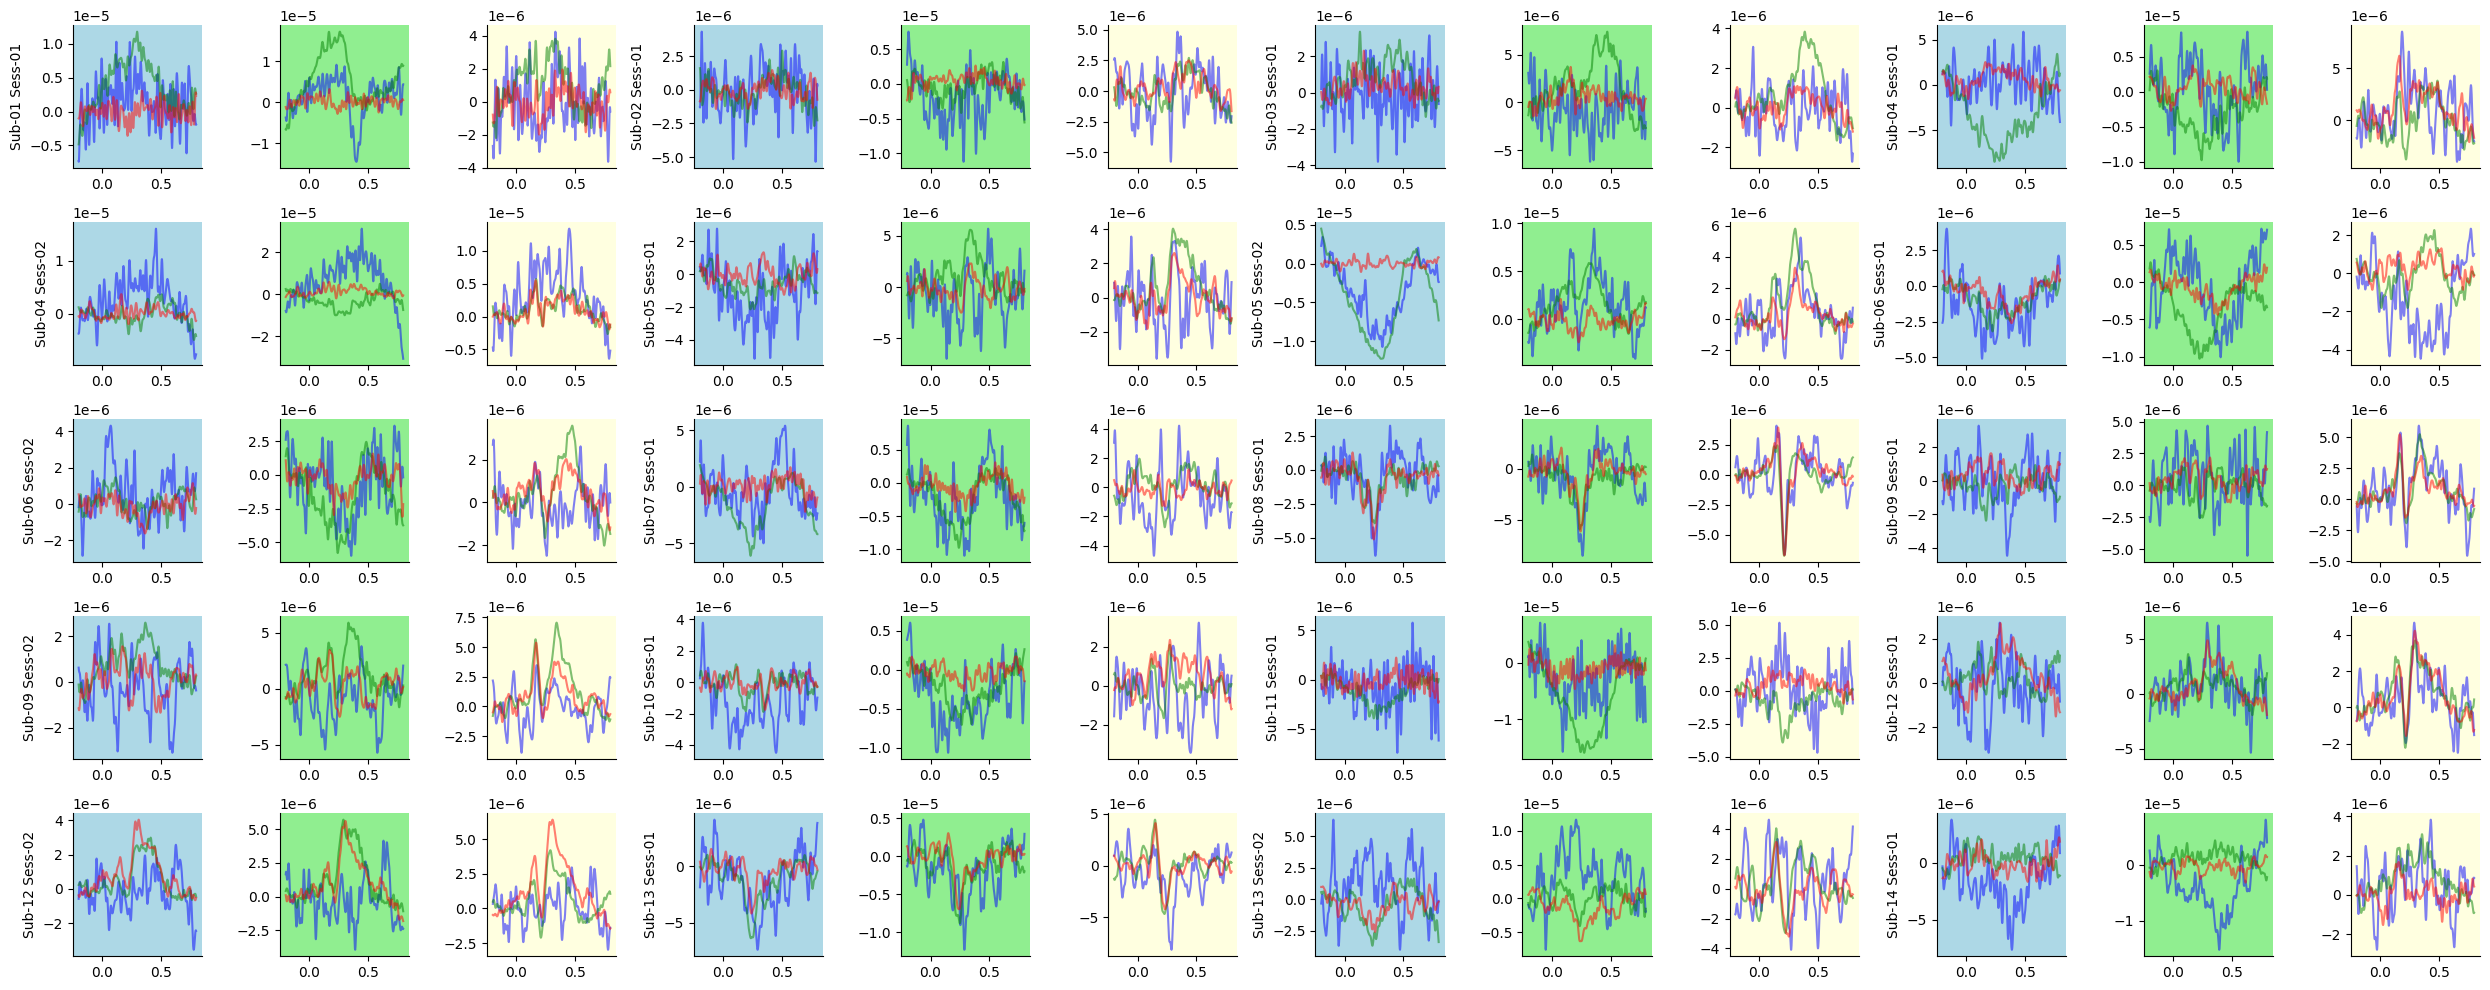

In [112]:
plot_erp_all_subjects_sessions(subjects_data)